In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2022-02-10 14:05:54.019262: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-10 14:05:54.019296: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", train_set_size = 200, test_set_path = "test_set", test_set_size = 50, validation_set_path = "validation_set", validation_set_size = 50, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    #unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = train_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = train_set_size + 1, sample_end = train_set_size + test_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = train_set_size + test_set_size + 1, sample_end = train_set_size + test_set_size + validation_set_size, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel):
    png_path = "dataset8x16/" + class_name + "/CH" + str(channel) + "/sample" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 7)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for i in range(7):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(10, 10)
    fig.set_figwidth(20)
    fig.set_figheight(24)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(10):
        for col in range(10):
            if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
            class_name = "P_x" + str(row + 1) + "_y" + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], channels), dtype="uint8")
    for ch in range(channels):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), rows = 10, cols = 10, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(rows):
            for col in range(cols):
                if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
                class_name = "P_x" + str(col + 1) + "_y" + str(row + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "sample_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)

def create_labeled_data(srs_path = "tensors", label_type = "categorical"):
    labeled_data = []
    categories = os.listdir(srs_path)
    categories.sort()
    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = P_x10_y2, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    if label_type == "regression":
        Y = to_regression(Y, categories)
    else:
        Y = np.array(Y)
        np.reshape(Y, (len(Y), 1))
        Y = to_categorical(Y)

    return X, Y

def to_regression(categorical_labels, categories):
    tensor = np.zeros((len(categorical_labels), 2))
    for i in range(len(categorical_labels)):
        category_name = categories[categorical_labels[i]]

        x_i = int(category_name.split("_")[1].split("x")[1]) - 1
        y_i = int(category_name.split("_")[2].split("y")[1]) - 1

        x_pos = 0.0935 * x_i + 0.012
        y_pos = 0.0973 * y_i + 0.012
        tensor[i,:] = [x_pos, y_pos]
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def compute_error(error_tensor):
    mse = ((error_tensor)**2).mean(axis=None)
    max_error = np.max(error_tensor)
    ave_error = sum(error_tensor) / len(error_tensor)
    return mse, ave_error, max_error

def evaluate_regression(model, val_X, val_Y, accuracy_threshold):
    model_output = model.predict(val_X)
    error_tensor = val_Y - model_output
    error_x_tensor = error_tensor[:,0]
    error_y_tensor = error_tensor[:,1]
    loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
    mse, ave_error, max_error = compute_error (loss_distance)
    accuracy = np.count_nonzero(loss_distance < accuracy_threshold) / len(loss_distance)
    return mse, ave_error, max_error, accuracy

def evaluate_regression_TF_Lite(interpreter, val_X, val_Y, accuracy_threshold):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    val_Y_lite = np.zeros((len(val_Y), 2))
    for i in range(len(val_X)):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(val_X[i], axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        val_Y_lite[i] = output_data

    error_tensor_lite = val_Y - val_Y_lite

    error_x_tensor_lite = error_tensor_lite[:,0]
    error_y_tensor_lite = error_tensor_lite[:,1]

    loss_distance_lite = np.sqrt(error_x_tensor_lite**2 + error_y_tensor_lite**2)

    accuracy_lite = np.count_nonzero(loss_distance_lite < accuracy_threshold) / len(loss_distance_lite)
    mse_lite, ave_error_lite, max_error_lite = compute_error(loss_distance_lite)
    return mse_lite, ave_error_lite, max_error_lite, accuracy_lite

def train_model(model, model_file_name = "model.h5", target_accuracy = 0.90, accuracy_threshold = 0.04):
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    current_accuracy = 0
    while (current_accuracy < target_accuracy):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=10, validation_data=(test_X, test_Y), verbose=1, callbacks=[monitor])
        #_, validation_accuracy = model.evaluate(val_X, val_Y, verbose=1)
        mse_, ave_error_, max_error_, validation_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
        if (current_accuracy < validation_accuracy):
            print("Validation accuracy > {:.2f}".format(validation_accuracy * 100.0))
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_accuracy = validation_accuracy
        else:
            if os.path.exists(model_file_name):
                model = load_model(model_file_name)

    print("{} has been trained, accuracy = {}.".format(model_file_name, current_accuracy))

def convert_to_TF_Lite_float32 (model_file_name):
  model = load_model(model_file_name)

  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

  os.system("xxd -i " + model_file_name + '.tflite' + " > " + model_file_name + '.cpp')

  print("{} has been converted to TF Lite (float32).".format(model_file_name))

def convert_to_TF_Lite_int8 (model_file_name, val_X):
  ds_cast = tf.cast(val_X, tf.float32)
  ds_batch = tf.data.Dataset.from_tensor_slices((ds_cast)).batch(1)
  def representative_dataset():
    for input_value in ds_batch.take(100):
      # Model has only one input so each data point has one element.
      yield [input_value]

  model = load_model(model_file_name)
  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + "_i8" + '.tflite', 'wb') as f:
    f.write(tflite_model)

  print("{} has been converted to TF Lite (int8).".format(model_file_name))

In [23]:
import struct

def bin2float(b):
    ''' Convert binary string to a float.

    Attributes:
        :b: Binary string to transform.
    '''
    h = int(b, 2).to_bytes(8, byteorder="big")
    return struct.unpack('>d', h)[0]


def float2bin(f):
    ''' Convert float to 64-bit binary string.

    Attributes:
        :f: Float number to transform.
    '''
    [d] = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

def quantize_float (float_number, exponent_bits, mantissa_bits):
    exponent_sign = 1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    if mantissa_bits < 0:
      mantissa_bits = 0
    if exponent_bits < 0:
      exponent_bits = 0
      
    coefficient = float2bin(float_number)
    sign = int (coefficient[:1], 2)
    if 0 < mantissa_bits:
        custom_mantissa = int (coefficient[12 : 12 + mantissa_bits], 2)
    else:
        custom_mantissa = 0
    residual_mantissa = int (coefficient[12 + mantissa_bits:], 2)
    exponent = int (coefficient[1:12], 2) - 1023

    exponent_full_range = pow(2, exponent_bits - exponent_sign) - 1
    if exponent < - exponent_full_range:
        quantized_value = 0
    elif exponent > exponent_full_range:
        quantized_value = pow(-1, sign) * (1 + (1 - pow(2, - mantissa_bits))) * pow(2, exponent_full_range)
    else:
        if (pow (2, (52 - (mantissa_bits + 1))) - 1) < residual_mantissa:
            custom_mantissa += 1
            if (pow (2, mantissa_bits) - 1) < custom_mantissa:
                custom_mantissa = 0
                exponent += 1
    
        quantized_value = pow(-1, sign) * (1 + custom_mantissa * pow(2, - mantissa_bits)) * pow(2, exponent)
    return quantized_value

def quantize_model(model, exponent_bits, mantissa_bits):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      for index in range(len(layer_weights)):
        matrix = layer_weights[index]
        for weight_index, weight in np.ndenumerate(matrix):
          matrix[weight_index] = quantize_float(weight, exponent_bits, mantissa_bits)
        layer_weights[index] = matrix
      layer.set_weights(layer_weights)

mantissa_bits = 1
exponent_bits = 4
class MyCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_file_name, threshold_accuracy):
    self.model_file_name = model_file_name
    self.current_accuracy = threshold_accuracy

  def on_epoch_end(self, epoch, logs = None):
    quantize_model(self.model, exponent_bits, mantissa_bits)
    mse_, ave_error_, max_error_, test_accuracy = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
    if (self.current_accuracy < test_accuracy):
      self.model.save(self.model_file_name)
      self.current_accuracy = test_accuracy
      print(" Saveing model ...")

    print(' Regression accuracy > %.3f' % (test_accuracy * 100.0))
  def on_train_end(self, logs = None):
    quantize_model(self.model, exponent_bits, mantissa_bits)
  def on_batch_end(self, epoch, logs = None):
    quantize_model(self.model, exponent_bits, mantissa_bits)

    mse_, ave_error_, max_error_, test_accuracy = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
    if (self.current_accuracy < test_accuracy):
      self.model.save(self.model_file_name)
      self.current_accuracy = test_accuracy
      print(" Saveing model ...")
      print(' Regression accuracy > %.3f' % (test_accuracy * 100.0))

def print_model(model):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      print (layer_weights)

In [4]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def CNN_categorical(input_shape = (32, 32, 4), output_categories = 16):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(output_categories, activation='softmax'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
model_file_name = "model_8x16x1.h5" # Set the file name for the model
target_accuracy = 0.96
accuracy_threshold = 0.04 # Radio-distance (in meters) to consider a correct regression

model_type = "regression" # set "regression" or "categorical"

zip_data_path = "dataset8x16.zip"

train_set_path = "train_set"
train_set_size = 1700

test_set_path = "test_set"
test_set_size = 400

validation_set_path = "validation_set"
validation_set_size = 400

crop_area = (0, 0, 16, 8) # x1, y1, x2, y2
size = (16, 8)

channel_sensors = 1

In [5]:
generate_datasets ( zip_data_path = zip_data_path,\
                    train_set_path = train_set_path,\
                    train_set_size = train_set_size,\
                    test_set_path = test_set_path,\
                    test_set_size = test_set_size,\
                    validation_set_path = validation_set_path,\
                    validation_set_size = validation_set_size,\
                    channels = channel_sensors, crop_area = crop_area, size = size)

In [6]:
train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 16, 40)         2200      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 16, 40)         160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 8, 40)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 8, 40)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 8, 60)          21660     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 8, 60)          240       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 4, 60)         

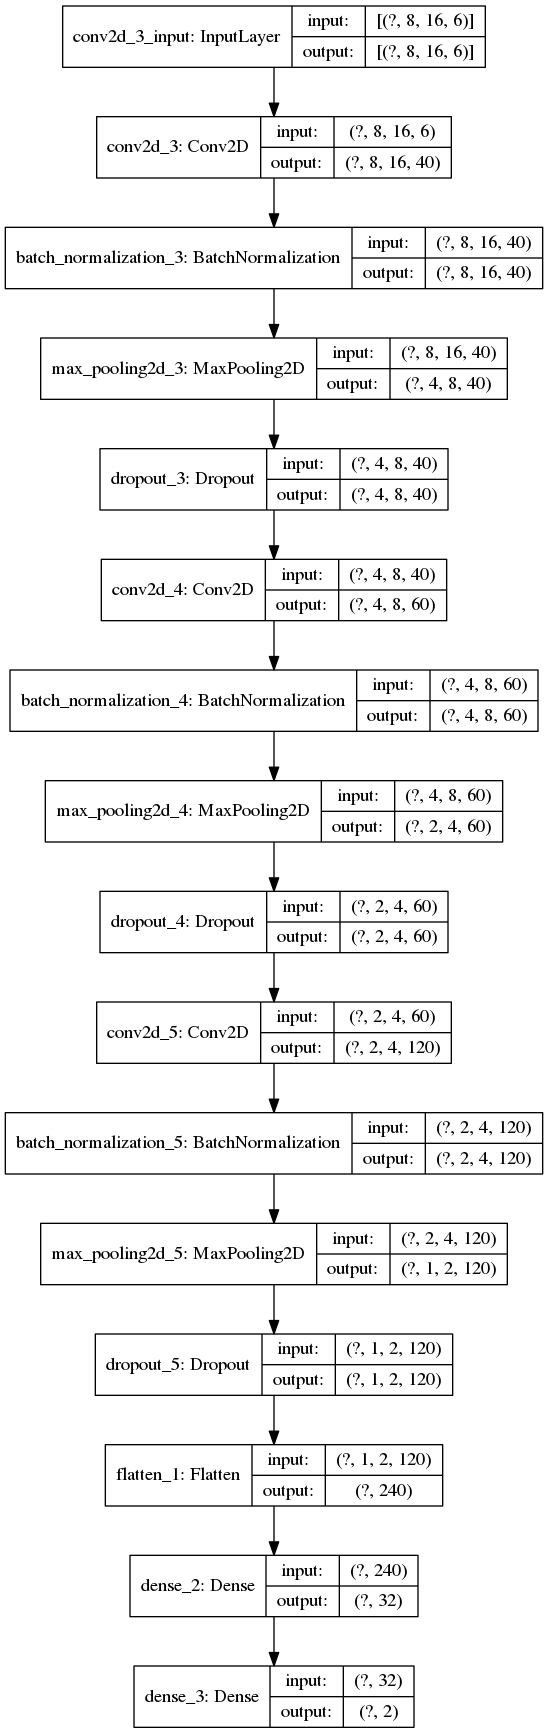

In [42]:
if model_type == "regression":
    model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
else:
    model = CNN_categorical(input_shape = (size[1], size[0], channel_sensors), output_categories = 16)

model.summary()

tf.keras.utils.plot_model(model, model_file_name + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

In [8]:
train_model(model = model, model_file_name = model_file_name, target_accuracy = target_accuracy, accuracy_threshold = accuracy_threshold)

2022-02-06 12:05:52.652827: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 501350400 exceeds 10% of free system memory.


Epoch 1/100
16317/16320 [============================>.] - ETA: 0s - loss: 0.5396 - accuracy: 0.9188

2022-02-06 12:09:08.026874: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 117964800 exceeds 10% of free system memory.


16320/16320 [==============================] - 204s 12ms/step - loss: 0.5396 - accuracy: 0.9188 - val_loss: 0.5258 - val_accuracy: 0.9539
Epoch 2/100
16320/16320 [==============================] - 218s 13ms/step - loss: 0.5280 - accuracy: 0.9519 - val_loss: 0.5244 - val_accuracy: 0.9770
Epoch 3/100
16320/16320 [==============================] - 226s 14ms/step - loss: 0.5267 - accuracy: 0.9648 - val_loss: 0.5246 - val_accuracy: 0.9847
Epoch 4/100
16320/16320 [==============================] - 237s 15ms/step - loss: 0.5260 - accuracy: 0.9695 - val_loss: 0.5238 - val_accuracy: 0.9907
Epoch 5/100
16320/16320 [==============================] - 240s 15ms/step - loss: 0.5256 - accuracy: 0.9711 - val_loss: 0.5235 - val_accuracy: 0.9866
Epoch 6/100
16320/16320 [==============================] - 246s 15ms/step - loss: 0.5253 - accuracy: 0.9732 - val_loss: 0.5232 - val_accuracy: 0.9873
Epoch 7/100
16320/16320 [==============================] - 247s 15ms/step - loss: 0.5251 - accuracy: 0.9742 - va

2022-02-06 12:54:46.053939: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 117964800 exceeds 10% of free system memory.


1200/1200 [==============================] - 5s 4ms/step - loss: 0.5232 - accuracy: 0.9878
Validation accuracy > 98.78
Saving model > model_8x16x6.h5
Done!


In [25]:
model = load_model(model_file_name)

mse, ave_error, max_error, accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse))
print("Ave error = {}".format(ave_error))
print("Max error = {}".format(max_error))
print("Accuracy = {}".format(accuracy))

Sensors = 1
MSE = 0.01061871422262446
Ave error = 0.08124749341235907
Max error = 0.7323305884490939
Accuracy = 0.23958333333333334


In [26]:
convert_to_TF_Lite_float32(model_file_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-02-10 21:40:58.454440: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpt40306vq/assets


2022-02-10 21:40:59.904608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 21:40:59.907898: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-02-10 21:40:59.909220: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-02-10 21:41:00.159835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 21:41:00.161508: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56486f96a2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-02-10 21:41:00.161525: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce GT

model_8x16x1.h5 has been converted to TF Lite (float32).


2022-02-10 21:41:00.358809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:313] Ignored output_format.
2022-02-10 21:41:00.358847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored drop_control_dependency.
2022-02-10 21:41:00.399019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 21:41:00.399815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 860M computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2022-02-10 21:41:00.399940: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-10 

In [27]:
convert_to_TF_Lite_int8(model_file_name = model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpyzw3qpej/assets


INFO:tensorflow:Assets written to: /tmp/tmpyzw3qpej/assets
2022-02-10 21:41:06.715031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 21:41:06.715784: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-02-10 21:41:06.715878: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-02-10 21:41:06.716925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 21:41:06.717859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 860M computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 5 deviceMemorySize: 1.96GiB devi

model_8x16x1.h5 has been converted to TF Lite (int8).


In [28]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

mse_lite, ave_error_lite, max_error_lite, accuracy_lite = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)


print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse_lite))
print("Ave error = {}".format(ave_error_lite))
print("Max error = {}".format(max_error_lite))
print("Accuracy = {}".format(accuracy_lite))

Sensors = 1
MSE = 0.011467705696283975
Ave error = 0.08378332151876848
Max error = 0.7361772811339756
Accuracy = 0.23169270833333333


In [ ]:
print ("_______ Post-training quantization _______")
model = load_model(model_file_name)
mse_, ave_error_, max_error_, pre_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

print('Original validation accuracy > %.3f' % (pre_accuracy * 100.0))

quantize_model(model, exponent_bits, mantissa_bits)
# evaluate model
mse_, ave_error_, max_error_, current_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
print_model (model)
print('Post-training quantization > %.3f' % (current_accuracy * 100.0))

print("Approximate floating-point quantization. Exponent = {}, Mantissa = {}.".format(exponent_bits, mantissa_bits))

print ("_______ Quantize aware training _______")
quantize_training_epochs = 100
quantize_training_patience = 10
training_batch_size = 2000
quantization_max_degradation = -0.1

quantize_loop = True
while quantize_loop:
    print ("Starting...")
    model = load_model(model_file_name)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=quantize_training_patience, verbose=1, mode='auto', restore_best_weights=True)
    history = model.fit(train_X, train_Y, epochs=quantize_training_epochs, batch_size=training_batch_size, validation_data=(test_X, test_Y), verbose=1, callbacks=[MyCallback(model_file_name, current_accuracy), monitor])
    # learning curves
    optimization_plot(history, "quantized_optimization")
    model = load_model(model_file_name)
    # evaluate model
    mse_, ave_error_, max_error_, current_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
    print('Quantize aware training > %.3f' % (current_accuracy * 100.0))
    quantize_loop = current_accuracy < pre_accuracy - quantization_max_degradation
    
print('Ending quantized aware training > %.3f' % (current_accuracy * 100.0))

In [127]:
file = validation_set_path + "/P_x1_y2/sample_2251.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

Input sample = validation_set/P_x1_y2/sample_2251.npy, model prediction = [[0.0040676  0.11258578]]


Grid (sample = 280, channels = 3)


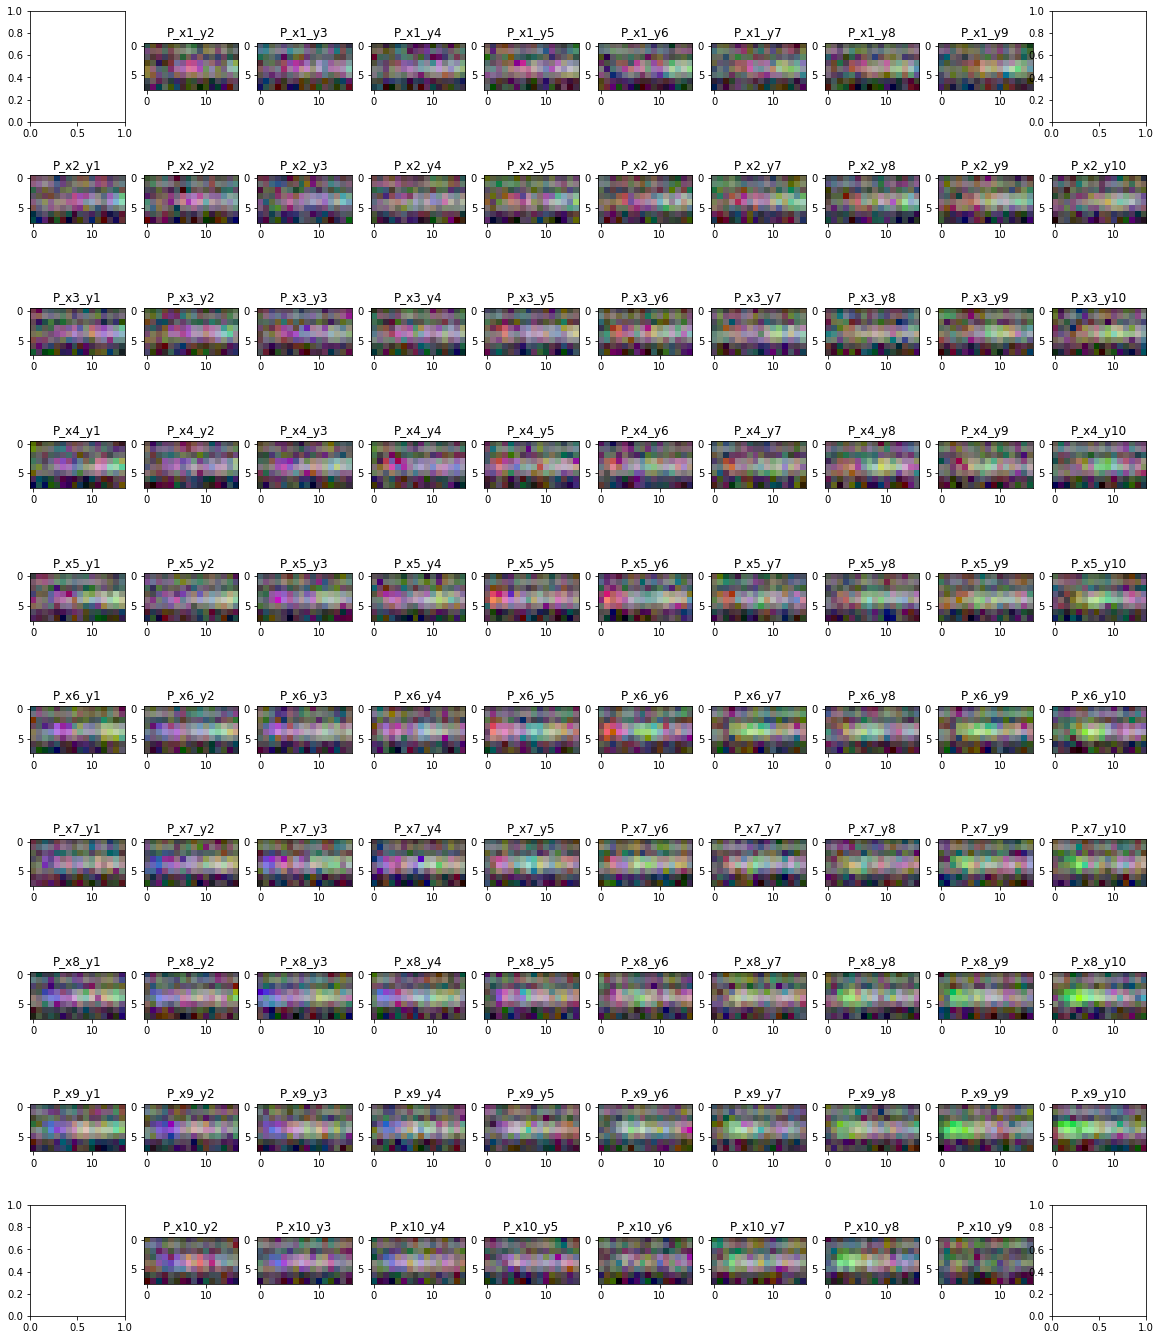

In [128]:
show_grid(sample = 280, channels = 3, crop_area = crop_area, size = size)

Sample = 280, class = P_x10_y9


/tmp/ipykernel_4992/3423935553.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


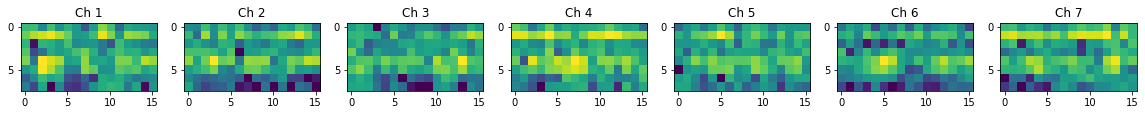

In [129]:
show_sample(class_name = "P_x10_y9", sample = 280, crop_area = crop_area, size = size)